In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
from datetime import datetime
from MCForecastTools import MCSimulation
%matplotlib inline

In [2]:
load_dotenv()

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [3]:
stock_dict = {}

stock_list = []

date = input("Pick a start date for your analysis (YYYY-MM-DD): ")

while (True):
    name = input("Add a stock ticker to the list: ")
    stock_dict[name] = date
    stock_list.append(name)
    cont = input("Press 'y' to Add Another Stock, press 'Enter' to exit")
    if cont == "":
        break;

Pick a start date for your analysis (YYYY-MM-DD):  2015-01-01
Add a stock ticker to the list:  TSLA
Press 'y' to Add Another Stock, press 'Enter' to exit y
Add a stock ticker to the list:  MSFT
Press 'y' to Add Another Stock, press 'Enter' to exit 


In [4]:
def stockCreation(stock_dict, stock_list):
    func_list = []
    today = datetime.now().strftime("%Y-%m-%d")
    today = pd.Timestamp(today, tz="America/New_York").isoformat()

    timeframe = "1D"

    portfolio = alpaca.get_barset(
        stock_list,
        timeframe,
        start = date,
        end = today
    ).df
    
    for key, value in stock_dict.items():
        globals()[key] = portfolio[key]["close"]
        func_list.append(globals()[key])
    
    portfolio_close = pd.concat(func_list, axis='columns', join='inner')
    portfolio_close.columns = stock_list
#     portfolio_close.index = portfolio.index.date
    
    return portfolio, portfolio_close


In [5]:
portfolio = stockCreation(stock_dict, stock_list)[0]
portfolio

MSFT                                         \
                             open      high      low     close    volume   
time                                                                       
2020-07-16 00:00:00-04:00  205.40  205.7000  202.310  203.9200  27155882   
2020-07-17 00:00:00-04:00  204.47  205.0400  201.390  202.8700  27682275   
2020-07-20 00:00:00-04:00  205.00  212.3000  203.010  211.4900  30878042   
2020-07-21 00:00:00-04:00  213.66  213.9400  208.030  208.7500  32788138   
2020-07-22 00:00:00-04:00  209.20  212.3000  208.390  211.7533  38475627   
...                           ...       ...      ...       ...       ...   
2020-11-30 00:00:00-05:00  214.10  214.7600  210.835  214.2400  24831149   
2020-12-01 00:00:00-05:00  214.51  217.3200  213.350  216.2100  25444010   
2020-12-02 00:00:00-05:00  214.88  215.4700  212.800  215.4200  17971949   
2020-12-03 00:00:00-05:00  214.61  216.3757  213.650  214.2700  19489315   
2020-12-04 00:00:00-05:00  214.22  215.3800  213.180  214.4000  19718805   

                              TSLA                                       
                              open     high      low    close    volume  
time                                                                     
2020-07-16 00:00:00-04:00  1477.16  1531.71  1466.00  1500.82  13562574  
2020-07-17 00:00:00-04:00  1513.45  1537.51  1490.00  1500.45   8970942  
2020-07-20 00:00:00-04:00  1519.01  1650.00  1488.00  1642.47  16510673  
2020-07-21 00:00:00-04:00  1639.93  1675.00  1558.00  1567.58  15315602  
2020-07-22 00:00:00-04:00  1599.00  1626.42  1562.00  1590.58  11174728  
...                            ...      ...      ...      ...       ...  
2020-11-30 00:00:00-05:00   602.21   607.80   554.51   566.48  56072877  
2020-12-01 00:00:00-05:00   597.59   597.85   572.05   585.19  37313883  
2020-12-02 00:00:00-05:00   556.44   571.54   541.21   568.80  42857218  
2020-12-03 00:00:00-05:00   590.02   598.97   582.43   593.28  38701927  
2020-12-04 00:00:00-05:00   591.01   599.00   585.50   599.00  27209889  

[100 rows x 10 columns]

In [6]:
portfolio_close = stockCreation(stock_dict, stock_list)[1]
portfolio_close

,TSLA,MSFT
time,,
2020-07-16 00:00:00-04:00,1500.82,203.9200
2020-07-17 00:00:00-04:00,1500.45,202.8700
2020-07-20 00:00:00-04:00,1642.47,211.4900
2020-07-21 00:00:00-04:00,1567.58,208.7500
2020-07-22 00:00:00-04:00,1590.58,211.7533
...,...,...
2020-11-30 00:00:00-05:00,566.48,214.2400
2020-12-01 00:00:00-05:00,585.19,216.2100
2020-12-02 00:00:00-05:00,568.80,215.4200


# Monte Carlo Simulation

## Definition: A broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. 

## Purpose: The underlying concept is to use randomness to solve problems that might be deterministic in principle.

In [7]:
def MonteCarlo(portfolio, portfolio_close):
    num_years = int(input("How many years do you want to run the Monte Carlo Simulation for?"))
    sims = int(input("How many simulations would you like to run?"))

    MC = MCSimulation(
        portfolio_data = portfolio,
        weights = np.full((1,len(portfolio_close.columns)), 1/len(portfolio_close.columns))[0].tolist(),
        num_simulation = sims,
        num_trading_days = 252*num_years
    )

    MC.calc_cumulative_return()

    line_plot = MC.plot_simulation();
    
    return line_plot

How many years do you want to run the Monte Carlo Simulation for? 5
How many simulations would you like to run? 200


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.


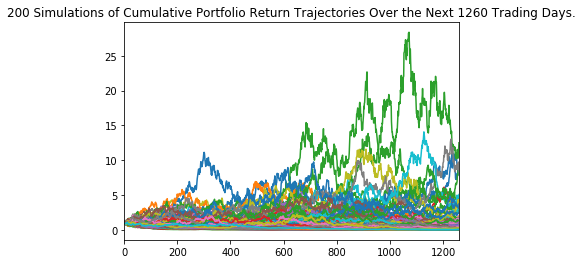

In [8]:
monte_carlo_line_plot = MonteCarlo(portfolio, portfolio_close)